
## Features from Khonji et al; 2012 ##

1.   b_dear = Binaray feature that returns 1 if word "dear" is found in the body of the message , else 0
2.   b_form = Does the message contain HTML form? (binary)
3. b_numwords = Total number of words found in body (cont.)
4. b_numchr = Total number of characters found in body (cont.)
5. b_numunique = A feature that returns the
total number of unique words found in the body a given
email message
6. b_numfunct = A feature that returns
the total number of function words found in the body of
a given email

## Features from TF-IDF ##

1. TF_IDF_click = How many times is the word click in the corpus and how does it correlate with our target variable.
2. TF_IDF_update = same as above
3. TF_IDF_secure = same as above
4. TF_IDF_security = same as above
5. TF_IDF_bank = same as above


## Overall Goal:
Identify if the following features from the academic papers can help us increase accuracy in our models

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import email
from datetime import datetime
from wordcloud import WordCloud
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import matplotlib.ticker as ticker

In [3]:
print(os.getcwd())

C:\Program Files\JetBrains\PyCharm 2024.3.4\bin


In [11]:
df_train = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\train_raw.csv')
df_test = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\test_raw.csv')
df_val = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\val_raw.csv')

Dataset Distribution
Email Type
Safe Email        7924
Phishing Email    5130
Name: count, dtype: int64


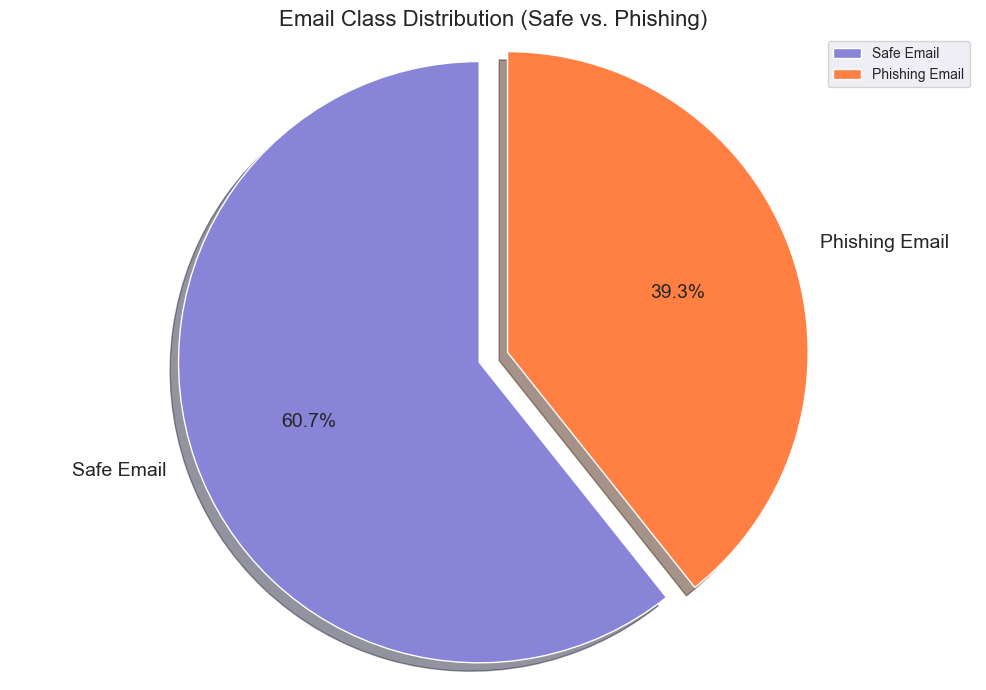

In [43]:
# EDA (Exploratory Data Analysis)

print("Dataset Distribution")

class_counts = train_features['Email Type'].value_counts()
print(class_counts)

# pie chart
plt.figure(figsize=(10, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90,
        colors=['#8884d8', '#FF8042'], explode=(0, 0.1), shadow=True, textprops={'fontsize': 14})

plt.axis('equal')
plt.title('Email Class Distribution (Safe vs. Phishing)', fontsize=16)
plt.legend(class_counts.index, loc="best")
plt.tight_layout()
plt.show()

In [39]:
def extract_features(df):
    # Initialize a dataframe to store features
    features_df = pd.DataFrame()

    # 1. b_dear - Binary feature for "dear" in body
    features_df['b_dear'] = df['Email Text'].apply(
        lambda x: 1 if 'dear' in str(x).lower() else 0
    )

    # 2. b_form - Does the message contain HTML form?
    features_df['b_form'] = df['Email Text'].apply(
        lambda x: 1 if '<form' in str(x).lower() else 0
    )

    # 3. b_numwords - Total number of words in body
    features_df['b_numwords'] = df['Email Text'].apply(
        lambda x: len(str(x).split())
    )

    # 4. b_numchr - Total number of characters in body
    features_df['b_numchr'] = df['Email Text'].apply(
        lambda x: len(str(x))
    )

    # 5. b_numunique - Total number of unique words
    features_df['b_numunique'] = df['Email Text'].apply(
        lambda x: len(set(str(x).lower().split()))
    )

    # 6. b_numfunct - Function words in body
    function_words = {
    "account", "access", "bank", "credit", "click", "identity",
    "inconvenience", "information", "limited", "log", "minutes",
    "password", "recently", "risk", "social", "security",
    "service", "suspended"
    }

    features_df['b_numfunct'] = df['Email Text'].apply(
        lambda x: sum(1 for word in str(x).lower().split() if word in function_words)
    )

    # Add target variable
    if 'Email Type' in df.columns:
        features_df['Email Type'] = df['Email Type']

    # THIS IS THE MISSING LINE
    return features_df

In [40]:
# Extract features for each dataset
train_features = extract_features(df_train)
val_features = extract_features(df_val)
test_features = extract_features(df_test)

# Display feature statistics
print("Training set features shape:", train_features.shape)
print("Validation set features shape:", val_features.shape)
print("Test set features shape:", test_features.shape)

# Display some sample data
print("\nSample of training features:")
print(train_features.head())

# Check for any missing values
print("\nMissing values in training set:")
print(train_features.isnull().sum())

Training set features shape: (13054, 7)
Validation set features shape: (2798, 7)
Test set features shape: (2798, 7)

Sample of training features:
   b_dear  b_form  b_numwords  b_numchr  b_numunique  b_numfunct  \
0       0       0         142       983          107           1   
1       0       0         291      3130          175           1   
2       0       0          42       221           35           0   
3       0       0          44       187           36           0   
4       0       0           6        34            6           0   

       Email Type  
0  Phishing Email  
1      Safe Email  
2      Safe Email  
3      Safe Email  
4  Phishing Email  

Missing values in training set:
b_dear         0
b_form         0
b_numwords     0
b_numchr       0
b_numunique    0
b_numfunct     0
Email Type     0
dtype: int64


In [41]:
# Feature summary and significance

train_features['target'] = train_features['Email Type'].apply(
    lambda x: 1 if x == 'Phishing Email' else 0
)

b_features = ['b_dear', 'b_form', 'b_numwords', 'b_numchr', 'b_numunique', 'b_numfunct']

# Corr with phishing emails
b_feature_correlation = []
for feature in b_features:
    corr = train_features[feature].corr(train_features['target'])
    b_feature_correlation.append(corr)

for feature, corr in zip(b_features, b_feature_correlation):
    print(f"{feature}: {corr:.4f}")

b_dear: 0.0851
b_form: nan
b_numwords: -0.0083
b_numchr: -0.0084
b_numunique: -0.0227
b_numfunct: -0.0041


D:\.venv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\.venv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [48]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

def extract_tfidf_features(df_train, df_test, df_val=None, max_features=100, custom_vocabulary=None):
    """
    Extract TF-IDF features from email text and add them to existing features.

    Parameters:
    -----------
    df_train : DataFrame
        Training dataset with 'Email Text' column
    df_test : DataFrame
        Test dataset with 'Email Text' column
    df_val : DataFrame, optional
        Validation dataset with 'Email Text' column
    max_features : int, default=100
        Maximum number of TF-IDF features to extract
    custom_vocabulary : list, optional
        List of specific terms to use in TF-IDF. If None, uses top max_features terms.

    Returns:
    --------
    tuple of DataFrames
        (train_features, test_features, val_features) with TF-IDF features added
    """
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        lowercase=True,
        vocabulary=custom_vocabulary,
        ngram_range=(1, 2)  # Include unigrams and bigrams
    )

    # Fit and transform on training data
    tfidf_train = tfidf_vectorizer.fit_transform(df_train['Email Text'].astype(str))

    # Transform test data
    tfidf_test = tfidf_vectorizer.transform(df_test['Email Text'].astype(str))

    # Transform validation data if provided
    if df_val is not None:
        tfidf_val = tfidf_vectorizer.transform(df_val['Email Text'].astype(str))

    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Convert TF-IDF matrices to DataFrames
    tfidf_train_df = pd.DataFrame(
        tfidf_train.toarray(),
        columns=[f'tfidf_{term}' for term in feature_names]
    )

    tfidf_test_df = pd.DataFrame(
        tfidf_test.toarray(),
        columns=[f'tfidf_{term}' for term in feature_names]
    )

    if df_val is not None:
        tfidf_val_df = pd.DataFrame(
            tfidf_val.toarray(),
            columns=[f'tfidf_{term}' for term in feature_names]
        )

    # Add original indices
    tfidf_train_df.index = df_train.index
    tfidf_test_df.index = df_test.index
    if df_val is not None:
        tfidf_val_df.index = df_val.index

    # Create return values
    if df_val is not None:
        return tfidf_train_df, tfidf_test_df, tfidf_val_df, feature_names
    else:
        return tfidf_train_df, tfidf_test_df, None, feature_names


# Example usage:
# Define phishing-related terms you want to specifically look for
phishing_vocabulary = [
    # Authentication and account-related
    'account', 'password', 'login', 'verify', 'confirmation', 'security',
    # Action words
    'update', 'confirm', 'validate', 'click', 'secure',
    # Urgency terms
    'urgent', 'immediately', 'alert', 'attention', 'important',
    # Banking and financial
    'bank', 'paypal', 'transaction', 'suspended', 'limited', 'access',
    # Common bigrams in phishing
    'account access', 'verify account', 'update information', 'security alert',
    'unusual activity', 'login attempt', 'confirm identity', 'account suspended',
    'security measure', 'customer service'
]

# Extract TF-IDF features using custom vocabulary
tfidf_train, tfidf_test, tfidf_val, feature_names = extract_tfidf_features(
    df_train,
    df_test,
    df_val,
    max_features=None,  # When using custom vocabulary, set to None
    custom_vocabulary=phishing_vocabulary
)

# Combine with existing features
train_features_with_tfidf = pd.concat([train_features, tfidf_train], axis=1)
test_features_with_tfidf = pd.concat([test_features, tfidf_test], axis=1)
val_features_with_tfidf = pd.concat([val_features, tfidf_val], axis=1)

# Now you can see which TF-IDF features are most correlated with phishing
# First, ensure we have the target column
train_features_with_tfidf['target'] = train_features_with_tfidf['Email Type'].apply(
    lambda x: 1 if x == 'Phishing Email' else 0
)

# Calculate correlation for TF-IDF features
tfidf_correlations = []
for feature in feature_names:
    feature_name = f'tfidf_{feature}'
    corr = train_features_with_tfidf[feature_name].corr(train_features_with_tfidf['target'])
    tfidf_correlations.append((feature, corr))

# Sort by absolute correlation
tfidf_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

# Print top correlated TF-IDF features
print("Top 5 TF-IDF features by correlation with phishing:")
for term, corr in tfidf_correlations[:5]:
    print(f"TF-IDF_{term}: {corr:.4f}")

Top 5 TF-IDF features by correlation with phishing:
TF-IDF_click: 0.2478
TF-IDF_update: -0.1001
TF-IDF_secure: 0.0866
TF-IDF_security: 0.0856
TF-IDF_bank: 0.0784


In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=100,  # Adjust as needed
    stop_words='english',
    lowercase=True
)

# Extract TF-IDF features from training data
tfidf_train = tfidf_vectorizer.fit_transform(df_train['Email Text'].astype(str))

# Convert to DataFrame with labeled columns
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(
    tfidf_train.toarray(),
    columns=[f'tfidf_{term}' for term in feature_names],
    index=df_train.index
)

tfidf_test = tfidf_vectorizer.transform(df_test['Email Text'].astype(str))

# Convert to DataFrame with the same columns
tfidf_test_df = pd.DataFrame(
    tfidf_test.toarray(),
    columns=[f'tfidf_{term}' for term in feature_names],
    index=df_test.index
)

# Combine with existing test features
test_features_with_tfidf = pd.concat([test_features, tfidf_test_df], axis=1)

# Combine with existing features
train_features_with_tfidf = pd.concat([train_features, tfidf_train_df], axis=1)

In [55]:
# Print all TF-IDF feature names to verify
print([col for col in train_features_with_tfidf.columns if col.startswith('tfidf_')])

['tfidf_00', 'tfidf_000', 'tfidf_10', 'tfidf_11', 'tfidf_12', 'tfidf_15', 'tfidf_1998', 'tfidf_20', 'tfidf_2000', 'tfidf_2001', 'tfidf_30', 'tfidf_50', 'tfidf_address', 'tfidf_available', 'tfidf_based', 'tfidf_best', 'tfidf_book', 'tfidf_business', 'tfidf_case', 'tfidf_click', 'tfidf_com', 'tfidf_company', 'tfidf_computer', 'tfidf_conference', 'tfidf_contact', 'tfidf_credit', 'tfidf_data', 'tfidf_date', 'tfidf_day', 'tfidf_does', 'tfidf_ect', 'tfidf_edu', 'tfidf_email', 'tfidf_english', 'tfidf_enron', 'tfidf_fax', 'tfidf_following', 'tfidf_form', 'tfidf_free', 'tfidf_group', 'tfidf_home', 'tfidf_hou', 'tfidf_html', 'tfidf_http', 'tfidf_include', 'tfidf_including', 'tfidf_information', 'tfidf_international', 'tfidf_internet', 'tfidf_john', 'tfidf_just', 'tfidf_know', 'tfidf_language', 'tfidf_languages', 'tfidf_like', 'tfidf_linguistic', 'tfidf_linguistics', 'tfidf_list', 'tfidf_mail', 'tfidf_make', 'tfidf_message', 'tfidf_money', 'tfidf_need', 'tfidf_net', 'tfidf_new', 'tfidf_number', '

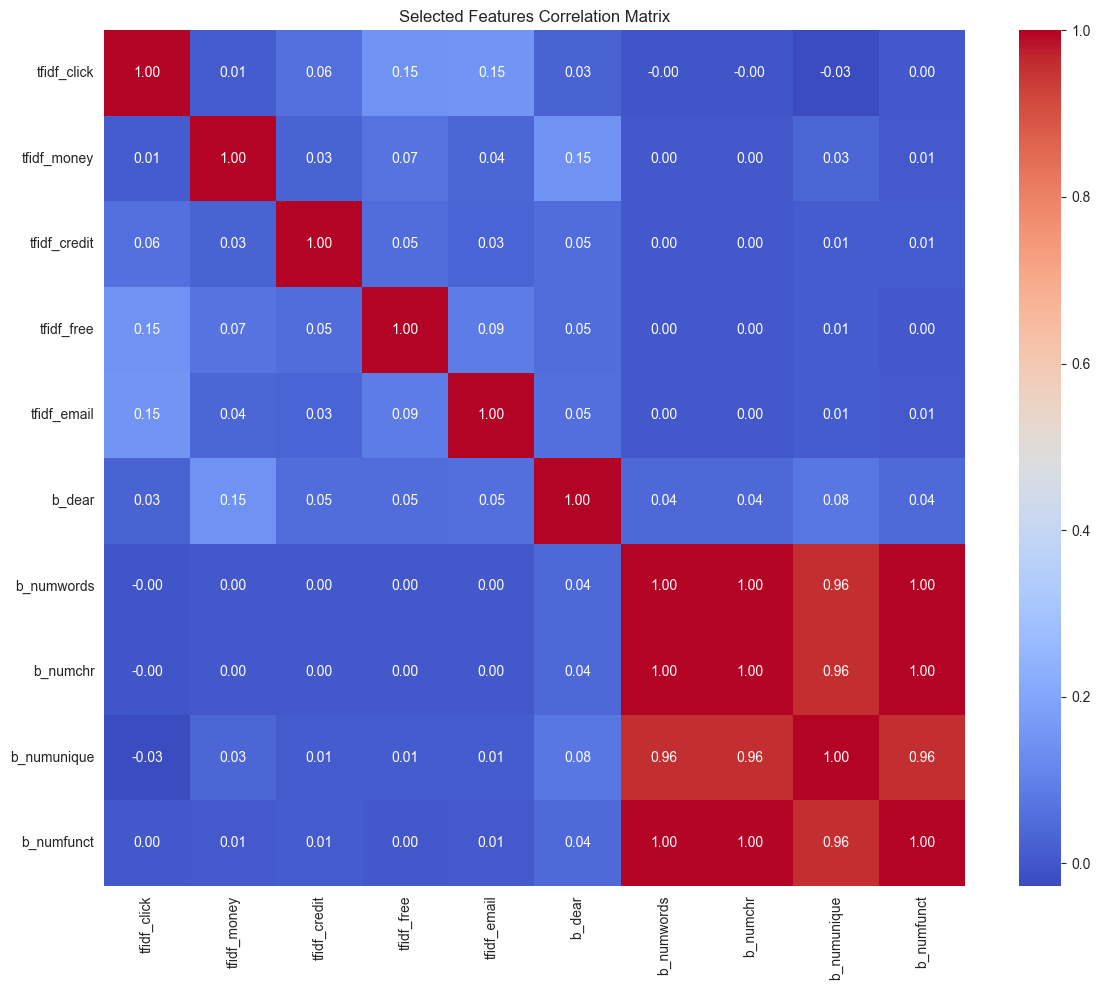

In [57]:
# Choose features that actually exist in your data
selected_features = [
    # TF-IDF features that exist in your data
    'tfidf_click', 'tfidf_money', 'tfidf_credit', 'tfidf_free', 'tfidf_email',
    # b_features
    'b_dear', 'b_numwords', 'b_numchr', 'b_numunique', 'b_numfunct',
    # Target
    'target'
]

# Select only these columns for the correlation matrix
selected_df = train_features_with_tfidf[selected_features]

# Create correlation matrix
plt.figure(figsize=(12, 10))
corr = selected_df.drop('target', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Selected Features Correlation Matrix')
plt.tight_layout()
plt.show()

In [60]:
# Define the features to keep
selected_features = [
    'tfidf_click', 'tfidf_money', 'tfidf_credit', 'tfidf_free', 'tfidf_email',
    'b_dear', 'b_form', 'b_numwords', 'b_numchr', 'b_numunique', 'b_numfunct'
]

# Keep only the selected features (this will modify the DataFrame in place)
train_features_with_tfidf = train_features_with_tfidf[selected_features]

In [96]:
print(train_features_with_tfidf.columns)
print(df_train.columns)

Index(['tfidf_click', 'tfidf_money', 'tfidf_credit', 'tfidf_free',
       'tfidf_email', 'b_dear', 'b_form', 'b_numwords', 'b_numchr',
       'b_numunique', 'b_numfunct'],
      dtype='object')
Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')


In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# Define the features to use
selected_features = [
    'tfidf_click', 'tfidf_money', 'tfidf_credit', 'tfidf_free', 'tfidf_email',
    'b_dear', 'b_form', 'b_numwords', 'b_numchr', 'b_numunique', 'b_numfunct'
]

# Split into features and target
X_train = train_features_with_tfidf[selected_features]
y_train = df_train['Email Type']

# Hyperparameters for RF Gridsearch
params_gridsearch = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf_base = RandomForestClassifier(random_state=42)

# Create and train the model
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=params_gridsearch,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2,  # Print progress
    scoring='accuracy'  # Metric to optimize
)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

# Cross-validation
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Cross-validation accuracy: 0.8136 ± 0.0058

Feature Importance:
         Feature  Importance
8       b_numchr    0.259567
7     b_numwords    0.196298
9    b_numunique    0.187847
1    tfidf_money    0.073113
0    tfidf_click    0.072948
10    b_numfunct    0.065049
4    tfidf_email    0.061880
3     tfidf_free    0.060967
2   tfidf_credit    0.014551
5         b_dear    0.007779
6         b_form    0.000000


Test accuracy: 0.8145

Classification Report:
                precision    recall  f1-score   support

Phishing Email       0.79      0.73      0.75      1099
    Safe Email       0.83      0.87      0.85      1699

      accuracy                           0.81      2798
     macro avg       0.81      0.80      0.80      2798
  weighted avg       0.81      0.81      0.81      2798



PermissionError: [Errno 13] Permission denied: 'confusion_matrix.png'

<Figure size 1000x800 with 0 Axes>

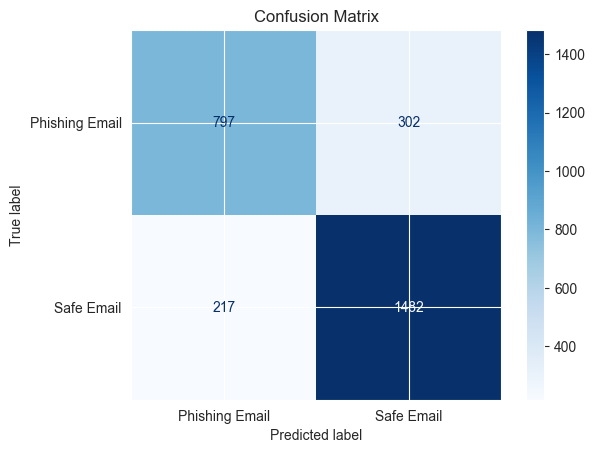

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you already have your trained RF model from before
# and you want to evaluate it on test data

# First, prepare your test features
X_test = test_features_with_tfidf[selected_features]  # Use the same features as training
y_test = df_test['Email Type']  # Your test labels

# Make predictions on test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', bbox_inches='tight')  # Save to file
plt.show()